<a href="https://colab.research.google.com/github/SRT-13/SEAP_2021/blob/main/SEAP_License_Plate_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload() #upload local_utils.py file into cloud if run on Google Colab

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from local_utils import detect_lp
from os.path import splitext, basename
from keras.models import model_from_json
import glob
#%matplotlib.inline


In [ ]:
files.upload() #upload wpod-net.h5 file into cloud if run on Google Colab
files.upload() #upload wpod-net.json file into cloud if run on Google Colab

In [ ]:
#loads wpod-net deep learning network
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)
        
wpod_net_path = "wpod-net.json"
wpod_net = load_model(wpod_net_path)

Loading model successfully...


In [ ]:
#changes color chanels if necessary
def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

In [ ]:
# Create a list of image paths 
%cd /content/drive/MyDrive/SEAP2021/Single_Car/Angled/ #change path to dataset of images
#image_paths = glob.glob("*.jpg")
image_paths = glob.glob("*.jpg") #find all images with .jpg file extension

print("Found %i images..."%(len(image_paths)))

# Visualize data in subplot 
fig = plt.figure(figsize=(12,8))
cols = 5
rows = 3
fig_list = [] 
for i in range(cols*rows):
    fig_list.append(fig.add_subplot(rows,cols,i+1))
    title = splitext(basename(image_paths[i]))[0] #titles for each license plate
    fig_list[-1].set_title(title)
    img = preprocess_image(image_paths[i],True) #preprocess the images to show them
    plt.axis(False)
    plt.imshow(img)

plt.tight_layout(True)
plt.show()

In [ ]:
def write_image(path, img):
    # img = img*(2**16-1)
    # img = img.astype(np.uint16)
    # img = img.astype(np.uint8)
    img = cv2.convertScaleAbs(img, alpha=(255.0))
    cv2.imwrite(path, img)

In [ ]:
#change image being analyzed
test_image = image_paths[8]

In [ ]:
from google.colab.patches import cv2_imshow

from skimage.util import random_noise
from PIL import Image

In [ ]:
#can add various noises and display them using this block of code

open_image = cv2.imread(test_image)
open_image = np.array(open_image)


noise_gs_img = random_noise(open_image,mode='gaussian', mean = 0, var = .05)
noise_sp_img = random_noise(open_image,mode='s&p',amount=0.29)
noise_speckle_img = random_noise(open_image,mode='speckle', mean = 0, var = 1.1 ** 2)
noise_poisson_img = random_noise(open_image,mode='poisson')
noise_gs_2 = random_noise(open_image,mode='gaussian', mean = .2, var = .05)


#graph the new images with noise
plt.subplot(2,3,1), plt.title('original')
plt.imshow(img)

plt.subplot(2,3,2),plt.title('gaussian')
plt.imshow(noise_gs_img)

plt.subplot(2,3,3),plt.title('s&p')
plt.imshow(noise_sp_img)

plt.subplot(2,3,4), plt.title('speckle')
plt.imshow(noise_speckle_img)
plt.show()

plt.subplot(2,3,5), plt.title('poisson')
plt.imshow(noise_poisson_img)
plt.show()

plt.subplot(2,3,6), plt.title('gaussian 2')
plt.imshow(noise_gs_2)
plt.show()

#save the images
write_image("noise_gs_img.jpg",noise_gs_img)
write_image("noise_sp_img.jpg",noise_sp_img)
write_image("noise_speckle_img.jpg",noise_speckle_img)
write_image("noise_poisson_img.jpg",noise_poisson_img)
write_image("noise_gs_2.jpg",noise_gs_2)

In [ ]:
from scipy.ndimage import median_filter

filtered_image = median_filter(noise_speckle_img, 2)
write_image("median_filtered_image.jpg",filtered_image)

In [ ]:
#gaussian_2
test_image = "noise_gs_2.jpg"

In [ ]:
#gaussian
test_image = "noise_gs_img.jpg"

In [ ]:
#speckle
test_image = "noise_speckle_img.jpg"

In [ ]:
#salt and pepper
test_image = "noise_sp_img.jpg"

In [ ]:
#median filter applied on salt and pepper image
test_image = "median_filtered_image.jpg"

In [ ]:
def get_plate(image_path, Dmax=608, Dmin=425):
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor, H = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return LpImg, cor, H

In [ ]:
!pip install easyocr
import easyocr

In [ ]:
#this was the main block of code used for testing

from scipy.ndimage import median_filter

#initialize arrays to save them later
lpList = []
lpPics = []

#initialize easyocr text recognition
reader = easyocr.Reader(['en'])

#add s&P noise with a random seed 100 different times, then add the noisy images to one array and text recognition outputs to another
for i in range (0,100):
  test_image = image_paths[8]

  open_image = cv2.imread(test_image)
  open_image = np.array(open_image)

  noise_sp_img = random_noise(open_image,mode='s&p',amount=0.575) #applied computational noise (salt and pepper)
  filtered_image = median_filter(noise_sp_img, 2) #median filter
  write_image("medianFiltered.jpg",filtered_image)

  #salt and pepper
  test_image = "medianFiltered.jpg"

  try: #try and catch error thrown when no license plate is detected in image and move onto next loop iteration
    LpImgN,_,_ = get_plate(test_image)
  except AssertionError:
    continue

  plateImage = cv2.convertScaleAbs(LpImgN[0], alpha=(255.0))

  lpPics.append(plateImage)

  result = reader.readtext(plateImage) #easyocr text reading

  lpList.append(result)

print("Number of license plates recognized")
print(len(lpList))
 


In [ ]:
#this block of code can be used to look at individual license plates and the corresponding text output
testNum = 66
print(lpList[testNum])
plt.imshow(lpPics[testNum])

In [ ]:
fig = plt.figure(figsize=(12,6))

#the row and column numbers need to be changed depeneding on how many total images have been extracted by the program.
cols = 6
rows = 4
fig_list = []

for i in range(cols*rows):

    fig_list.append(fig.add_subplot(rows,cols,i+1))

    #title = lpList[i]
    #fig_list[-1].set_title(title)

    plt.axis(False)
    plt.imshow(lpPics[i])

plt.tight_layout(True)
plt.show()

In [ ]:
for j in range (len(lpList)):
  print(lpList[j])

In [ ]:
import re

confidenceList = []
textList = []

#match = re.match('[a-zA-Z]{2,3}\D?\d{3,4}$',test_string)
#boolean = bool(match)

testNum = 0
index = lpList[testNum]


for item in lpList:
  for tup in item:
    if (bool(re.match('[a-zA-Z]{2,4}\D?\d{2,4}$',tup[1]))):
      confidenceList.append(tup[2])
      textList.append(tup[1])
    #print(tup[1])

plt.imshow(lpPics[testNum])

In [ ]:
print(confidenceList)
print(len(confidenceList))


print(np.std(confidenceList))
print(np.mean(confidenceList))
print(np.median(confidenceList))


[]
0
nan
nan
nan


/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
#save data stored in arrays in .npy file format

np.save("57.5_filtered_textList.npy",textList) #full, unparsed output from compiling easyocr text - not technically needed
np.save("57.5_filtered_confidenceList.npy",confidenceList) #compiled list of confidence numbers 
np.save("57.5_filtered_text.npy",lpList)
np.save("57.5_filtered_pics.npy",lpPics)

In [ ]:
#load data already saved and convert to .csv file so it can be easily copied to excel
histArray = np.load("50_filtered_confidenceList.npy")
np.savetxt("HistogramTest.csv",histArray)


In [ ]:
#testing regular expression rule for filtering through confidence numbers

import re
test_string = 'abc-123'
#valid = re.compile()
#displaymatch(valid.match(test_string))

match = re.match('[a-zA-Z]{2,3}\D?\d{3,4}$',test_string)
boolean = bool(match)
print(boolean)

#displaymatch(match)

True


In [ ]:
#distance calculation

corWidth = cor[0][0][1] - cor[0][0][0]
print(corWidth)

corHeight = cor[0][1][3] - cor[0][1][0]
print(corHeight)

print(corWidth/corHeight) #ratio of length of license plate to width - ideally should be 2:1

263.7126270466201
156.0178484360656
1.690272168794115


In [ ]:
#Extract mutiple plate license in one image 
#not technically needed

multiple_plates_image = test_image
LpImg,cor,H = get_plate(multiple_plates_image)

print("Detect %i plate(s) in"%len(LpImg),splitext(basename(multiple_plates_image))[0])

# Visualize the original image
plt.figure(figsize=(10,5))
plt.axis(False)
plt.imshow(preprocess_image(multiple_plates_image))

# Visualize the obtained plates
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.axis(True)
plt.imshow(LpImg[1])
plt.subplot(1,2,2)
plt.axis(True)
plt.imshow(LpImg[0])

In [ ]:
#visualize where the corners of the license plate are using circles

from matplotlib.patches import Circle
from scipy import ndimage

#plt.figure(figsize=(10,5))

img1 = plt.imread(test_image)

# Create a figure. Equal aspect so circles look circular
fig,ax = plt.subplots(1)
ax.set_aspect('equal')

fig.set_figwidth(60)
fig.set_figheight(30)

# Show the image
img1 = ndimage.rotate(img1, 0)

ax.imshow(img1)

# create a circle at each x,y pair
circ1 = Circle((1697,2122),5)
circ1.set_facecolor("r")
ax.add_patch(circ1)



# Show the image
plt.show()


In [ ]:
#attempt to extract homography matrix used to warp the license plate and apply it to the entire inital image

from google.colab.patches import cv2_imshow
print(H)
im_src = cv2.imread(test_image)

#im_out = cv2.warpPerspective(im_src, H, (im_src.shape[1],im_src.shape[0]),flags=cv2.INTER_LINEAR)
im_out = cv2.warpPerspective(im_src, H, (im_src.shape[1],im_src.shape[0]))
padded = cv2.copyMakeBorder(im_out,350,0,200,200,cv2.BORDER_CONSTANT)


plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.axis(True)


plt.imshow(im_out)
#plt.imshow(padded)

# Show the image
plt.show()



#cv2_imshow(im_src)
#cv2_imshow(im_out)
#cv2_imshow(padded)


In [ ]:
#perform measurement for program's blox plotting accuracy

import math
manual_array = np.zeros((2,4))

#print(cor[0][0])
#print(cor[0][1])

#Order - Top left, top right, bottom right, bottom left

#x-coordinates
manual_array[0,0] = 1696
manual_array[0,1] = 2014
manual_array[0,2] = 2014
manual_array[0,3] = 1697

#y-coordinates
manual_array[1,0] = 1963
manual_array[1,1] = 1964
manual_array[1,2] = 2122
manual_array[1,3] = 2122

#length of side
side_length = manual_array[0,1] - manual_array[0,0]


print("Side length: ")
print(side_length)
print("\n")

#print(manual_array)

#Top left
distance1 = math.sqrt(((cor[0][0][0]-manual_array[0,0])**2) + ((cor[0][1][0]-manual_array[1,0])**2))

#Top right
distance2 = math.sqrt(((cor[0][0][1]-manual_array[0,1])**2) + ((cor[0][1][1]-manual_array[1,1])**2))

#Bottom right
distance3 = math.sqrt(((cor[0][0][2]-manual_array[0,2])**2) + ((cor[0][1][2]-manual_array[1,2])**2))

#Bottom left
distance4 = math.sqrt(((cor[0][0][3]-manual_array[0,3])**2) + ((cor[0][1][3]-manual_array[1,3])**2))

measure1 = math.sqrt(.25*(distance1**2 + distance2**2 + distance3**2 + distance4**2))
print("RMS: ")
print(measure1) #RMS
print("\n")

print("Average Distances: ")
measure2 = (distance1 + distance2 + distance3 + distance4)/4
print(measure2)
print("\n")

print("(RMS/Side-Length) for normalization: ")
print(measure1/side_length)

print("\n")
print("Distances:")
print(distance1)
print(distance2)
print(distance3)
print(distance4)

In [ ]:
#draw box after obtaining image coordinates

def draw_box(image_path, cor, thickness=3):
    pts=[]  
    x_coordinates=cor[0][0]
    y_coordinates=cor[0][1]
    # store the top-left, top-right, bottom-left, bottom-right 
    # of the plate license respectively
    for i in range(4):
        pts.append([int(x_coordinates[i]),int(y_coordinates[i])])
    
    pts = np.array(pts, np.int32)
    pts = pts.reshape((-1,1,2))
    vehicle_image = preprocess_image(image_path)
    
    cv2.polylines(vehicle_image,[pts],True,(0,255,0),thickness)
    return vehicle_image

plt.figure(figsize=(8,8))
plt.axis(False)
plt.imshow(draw_box(test_image,cor))

In [ ]:
# Viualize all obtained plate images 
fig = plt.figure(figsize=(12,6))
cols = 3
rows = 3
fig_list = []

for i in range(cols*rows):
    fig_list.append(fig.add_subplot(rows,cols,i+1))
    title = splitext(basename(image_paths[i]))[0]
    fig_list[-1].set_title(title)
    LpImg,_ = get_plate(image_paths[i])
    plt.axis(False)
    plt.imshow(LpImg[0])

plt.tight_layout(True)
plt.show()

200


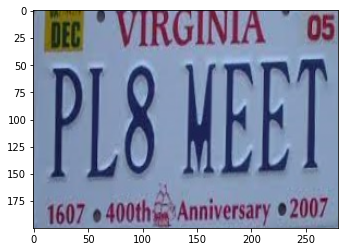

In [ ]:
#Change image being analyzed by changing index in image_paths
LpImg,_,_ = get_plate(image_paths[8])
plt.imshow(LpImg[0])

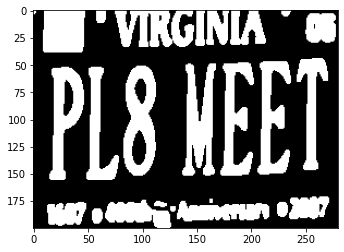

In [ ]:
#preprocessing to see if it helps program recognize letters and numbers on license plate

if (len(LpImg)): #check if there is at least one license image
    # Scales, calculates absolute values, and converts the result to 8-bit.
    
    plate_image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))
    
    # convert to grayscale and blur the image
    gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(7,7),0)
    
    # Applied inversed thresh_binary 
    binary = cv2.threshold(blur, 255, 255,
                         cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    ## Applied dilation 
    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)
    plt.imshow(thre_mor, cmap = 'gray')



In [ ]:
#install easyocr onto local runtime
!pip install easyocr

     |████████████████████████████████| 63.2MB 50kB/s 


In [ ]:
import easyocr

In [ ]:
#output for easyocr
reader = easyocr.Reader(['en'])
reader1 = easyocr.Reader(['en'])

result = reader.readtext(plate_image)
print(result)
result = reader1.readtext(thre_mor)
print(result)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[148, 16], [376, 16], [376, 40], [148, 40]], 'JRSAA', 0.09143357368574807), ([[51, 31], [470, 31], [470, 99], [51, 99]], 'UPH-8620', 0.8974830767621826)]
[([[184, 16], [274, 16], [274, 40], [184, 40]], 'Jrc?[', 0.08942156846372966), ([[51, 19], [470, 19], [470, 110], [51, 110]], 'TPH.820', 0.4080873556925826)]


In [ ]:
#download and install tesseract onto Google Colab runtime
!pip install tesseract
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 39 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (5,520 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [ ]:
#setup for tesseract-ocr
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

In [ ]:
#output of tesseract-ocr
print(pytesseract.image_to_string(plate_image))
print(pytesseract.image_to_string(thre_mor))

   

VIRGINIA

UPH-8620

 



<class 'list'>
Detect 6 letters...


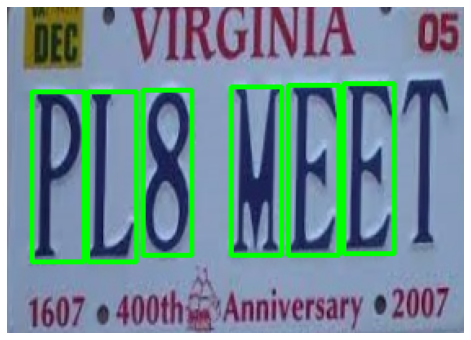

In [ ]:
# Create sort_contours() function to grab the contour of each digit from left to right
def sort_contours(cnts,reverse = False):
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts

cont, _  = cv2.findContours(thre_mor, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(type(cont))
#print(cont)

#cnt1 = cont[1]
#cv2.drawContours(thre_mor, [cnt1], 0, (0,255,0), 3)
#plt.imshow(thre_mor, cmap = 'gray')

# creat a copy version "test_roi" of plat_image to draw bounding box
test_roi = plate_image.copy()

# Initialize a list which will be used to append charater image
crop_characters = []

# define standard width and height of character
digit_w, digit_h = 25, 45

for c in sort_contours(cont):
    (x, y, w, h) = cv2.boundingRect(c)
    ratio = h/w
    if 1<=ratio<=3.5: # Only select contour with defined ratio
        if h/plate_image.shape[0]>=0.5: # Select contour which has the height larger than 50% of the plate
            # Draw bounding box arroung digit number
            cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)

            # Sperate number and give prediction
            curr_num = thre_mor[y:y+h,x:x+w]
            curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
            _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            crop_characters.append(curr_num)



print("Detect {} letters...".format(len(crop_characters)))
fig = plt.figure(figsize=(10,6))
plt.axis(False)
plt.imshow(test_roi)
#plt.savefig('grab_digit_contour.png',dpi=300)


<class 'list'>
Detect 6 letters...


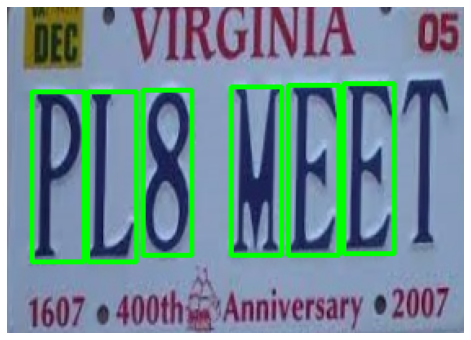

In [ ]:
# Create sort_contours() function to grab the contour of each digit from left to right
def sort_contours(cnts,reverse = False):
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts

cont, _  = cv2.findContours(thre_mor, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(type(cont))


# creat a copy version "test_roi" of plat_image to draw bounding box
test_roi = plate_image.copy()

# Initialize a list which will be used to append charater image
crop_characters = []

# define standard width and height of character
digit_w, digit_h = 30, 70


 
for c in sort_contours(cont):
    (x, y, w, h) = cv2.boundingRect(c)
    ratio = h/w
    if 1<=ratio<=3.5: # Only select contour with defined ratio
        if 0.5<=h/plate_image.shape[0]: # Select contour which has the height larger than 50% of the plate
            # Draw bounding box arroung digit number
            cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)

            # Sperate number and gibe prediction
            curr_num = thre_mor[y:y+h,x:x+w]
            curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
            _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            crop_characters.append(curr_num)

print("Detect {} letters...".format(len(crop_characters)))

fig = plt.figure(figsize=(10,6))
plt.axis(False)
plt.imshow(test_roi)
#plt.savefig('grab_digit_contour.png',dpi=300)


In [ ]:
fig = plt.figure(figsize=(14,4))
grid = gridspec.GridSpec(ncols=len(crop_characters),nrows=1,figure=fig)

for i in range(len(crop_characters)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.imshow(crop_characters[i],cmap="gray")

<Figure size 1008x288 with 0 Axes>

In [ ]:
import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Load model architecture, weight and labels
json_file = open('MobileNets_character_recognition.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("License_character_recognition_weight.h5")
print("[INFO] Model loaded successfully...")

labels = LabelEncoder()
labels.classes_ = np.load('license_character_classes.npy')
print("[INFO] Labels loaded successfully...")

[INFO] Model loaded successfully...
[INFO] Labels loaded successfully...


Achieved result:  PL8UEE


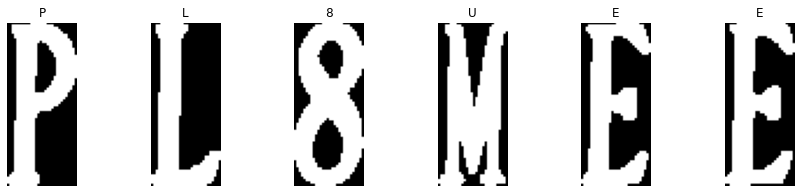

In [ ]:
# pre-processing input images and pedict with model
def predict_from_model(image,model,labels):
    image = cv2.resize(image,(80,80))
    image = np.stack((image,)*3, axis=-1)
    prediction = labels.inverse_transform([np.argmax(model.predict(image[np.newaxis,:]))])
    return prediction
    
fig = plt.figure(figsize=(15,3))
cols = len(crop_characters)
grid = gridspec.GridSpec(ncols=cols,nrows=1,figure=fig)

final_string = ''
for i,character in enumerate(crop_characters):
    fig.add_subplot(grid[i])
    title = np.array2string(predict_from_model(character,model,labels))
    plt.title('{}'.format(title.strip("'[]"),fontsize=20))
    final_string+=title.strip("'[]")
    plt.axis(False)
    plt.imshow(character,cmap='gray')

print("Achieved result: ", final_string)
#plt.savefig('final_result.png', dpi=300)